## Train the GAT Classifier

In this Section we train a simple GAT classifier which is composed of a variable number of GAT layers and a simple MLPNN with three linear layers that gradually reduces the output size to $2$ in the final layer to give the classification probabilities for our binary classification task. We use `Relu()` as non-linearities and add a dropout layer inbetween the linear layers.

For the GAT layers we always choose 4 attention heads and optimize over the remaining hyperparameters. We also aggregate the node representation to a graph representation for graph classification after the GAT layers via a `global_mean_pool`.

The model is defined in `models.py`.

In this notebook we perform a hyperparameter sweep and choose the best model according to accuracy, balanced accuracy (due to the class imbalance) and AUC. We then train the best model and use it to classify the test set.

We use 10-fold stratified cross-validation for steps 1 and 2.

---

## Notebook Contents
1. [**Hyperparameter Scan**](#scan): Scan through a range of hyperparameters and find best model.
2. [**Benchmark Best Model**](#explore): Train best model and get statistical information.
3. [**Evaluate Test Set**](#test): Evaluate model on test set

---

Load relevant modules

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
import random
from torch_geometric.loader import DataLoader, ImbalancedSampler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve,
    precision_recall_curve, balanced_accuracy_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

Set random seeds to make results reproducible (see https://docs.pytorch.org/docs/stable/notes/randomness.html)

In [3]:
rnd_seed=1

random.seed(rnd_seed)
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(rnd_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(rnd_seed)

Load dataset and split it into train and test set (90% - 10%)

In [4]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])
train_set, _ , test_set = random_split_dataset(ds, frac_train=0.9, frac_val=0.0, frac_test=0.1)

skf = StratifiedKFold(n_splits=10)

## 1. Hyperparameter Scan
<a id='scan'></a>

We now scan over the following hyperparameters:
- dropout in [0.2, 0.4, 0.6]
- number of GAT layers in [2, 3, 4]
- feature dimension in hidden layers [32, 64]
- learing rate in [5e-3, 1e-3, 5e-4]

We use 10-fold startified cross-validation to get a statistically meaningful comparison. For each fold we keep the batch size fixed to 64 and train the network for 50 epochs and save the validation accuracy, balanced accuracy and AUC to compare all models.

In [5]:
from models import simpleGAT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64

dropout_list = [0.2, 0.4, 0.6]
num_layer_list = [2, 3, 4]
num_hidden_list = [32, 64]
lr_list = [5e-3, 1e-3, 5e-4]
model_summary = []
train_class_label = np.array([0 if e==[1,0] else 1 for e in train_set.y.view(-1,2)])

for do in dropout_list:
    for num_l in num_layer_list:
        for num_h in num_hidden_list:
            for lr in lr_list:
                acc_list = []
                auc_list = []
                bal_acc_list = []
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}')

                for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
                    trainfold = train_set[train_index]
                    valfold = train_set[test_index]
                    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
                    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
                    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

                    model = simpleGAT(in_channels=trainfold[0].x.size(1), dim_h=num_h, out_channels=trainfold[0].y.size(0), num_layers=num_l, heads=4, dropout=do).to(device)

                    trainer = Trainer(model=model,
                                      train_loader=train_dataloader,
                                      val_loader=val_dataloader,
                                      test_loader=None,
                                      device=device,
                                      save_dir=None,)
                    
                    train_params = {'num_epochs': 50,
                                    'num_early_stop': 0,
                                    'step': 20,
                                    'gamma': 0.5}
                    
                    optimizer_params = {'lr': lr,
                                        'weight_decay': 1e-5}
                    
                    eval_acc, eval_auc, eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=False,)
                    acc_list.append(eval_acc)
                    auc_list.append(eval_auc)
                    bal_acc_list.append(eval_bal_acc)
                
                model_summary.append({'num_layer': num_l,
                                      'num_hidden': num_h,
                                      'dropout': do,
                                      'lr': lr,
                                      'mean_acc': np.mean(acc_list),
                                      'std_acc': np.std(acc_list),
                                      'mean_auc': np.mean(auc_list),
                                      'std_auc': np.std(auc_list),
                                      'mean_bal_acc': np.mean(bal_acc_list),
                                      'std_bal_acc': np.std(bal_acc_list)})
                
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}: accuracy={np.mean(acc_list):.4f}±{np.std(acc_list):.4f}, balanced accuracy={np.mean(bal_acc_list):.4f}±{np.std(bal_acc_list):.4f}, AUC={np.mean(auc_list):.4f}±{np.std(auc_list):.4f}')
                    


Model with num_hidden=32, num_layer=2, lr=0.0050, dropout=0.2000
Epoch 50: Training_loss:0.2161, Training_acc:0.9120, Training_auc:0.9138, Training_bal_acc:0.7148, Eval_loss:0.2222, Eval_acc:0.9149, Eval_auc:0.8893, Eval_bal_acc:0.6653
Epoch 50: Training_loss:0.1865, Training_acc:0.9276, Training_auc:0.9319, Training_bal_acc:0.7383, Eval_loss:0.2651, Eval_acc:0.9045, Eval_auc:0.8651, Eval_bal_acc:0.7016
Epoch 50: Training_loss:0.1933, Training_acc:0.9301, Training_auc:0.9136, Training_bal_acc:0.7367, Eval_loss:0.2778, Eval_acc:0.8976, Eval_auc:0.8674, Eval_bal_acc:0.6692
Epoch 50: Training_loss:0.2064, Training_acc:0.9204, Training_auc:0.9151, Training_bal_acc:0.7280, Eval_loss:0.2553, Eval_acc:0.9062, Eval_auc:0.8854, Eval_bal_acc:0.7202
Epoch 50: Training_loss:0.2202, Training_acc:0.9116, Training_auc:0.9043, Training_bal_acc:0.6924, Eval_loss:0.2429, Eval_acc:0.9149, Eval_auc:0.8894, Eval_bal_acc:0.7225
Epoch 50: Training_loss:0.2126, Training_acc:0.9146, Training_auc:0.9185, Traini

The results show that the model with 4 layers, feature dimension in the hidden layer of 64, dropout of 0.4 and a learning rate of 0.001 gives the best balanced accuracy, AUC and accuracy.

In [6]:
import pandas as pd

scan_results = pd.DataFrame(model_summary)
scan_results.sort_values("mean_bal_acc", ascending=False)

,num_layer,num_hidden,dropout,lr,mean_acc,std_acc,mean_auc,std_auc,mean_bal_acc,std_bal_acc
34,4,64,0.4,0.0010,0.909201,0.014127,0.889807,0.026923,0.732725,0.037621
35,4,64,0.4,0.0005,0.905035,0.016379,0.883372,0.025003,0.732219,0.045521
28,3,64,0.4,0.0010,0.907118,0.009517,0.884312,0.023453,0.727356,0.046188
4,2,64,0.2,0.0010,0.910937,0.015412,0.886657,0.026446,0.722251,0.047658
14,4,32,0.2,0.0005,0.904687,0.014863,0.882056,0.024513,0.720557,0.027627
16,4,64,0.2,0.0010,0.913194,0.009973,0.887962,0.022801,0.720242,0.026152
12,4,32,0.2,0.0050,0.909896,0.015920,0.884895,0.026468,0.718941,0.047804
22,2,64,0.4,0.0010,0.909201,0.014773,0.885956,0.020579,0.716641,0.032973
7,3,32,0.2,0.0010,0.909375,0.012563,0.884373,0.021419,0.715816,0.027155
1,2,32,0.2,0.0010,0.906597,0.013353,0.884084,0.020430,0.715738,0.048850


In [7]:
scan_results.to_csv(os.path.join(os.getcwd(), "scan_results/GAT_scan_results.csv"), index=False)

## 2. Benchmark Best Model
<a id='explore'></a>

Now we want to know how well the best model can perform. We use the best hyperparameters from the scan and train for 200 epochs and save the model after the epoch with the best balanced accuracy on the validation set. In order to get a statistically meaningful result we again do this with 10-fold stratified cross-validation.

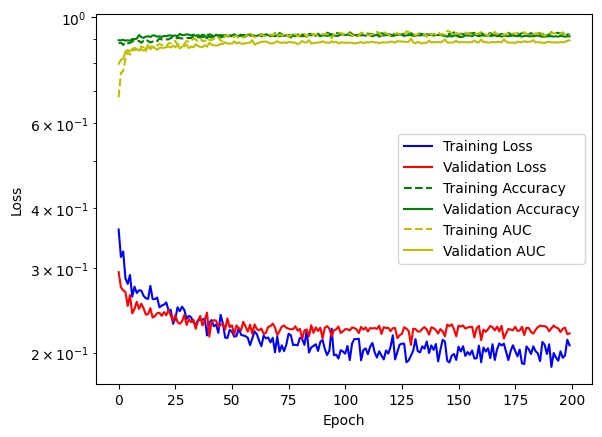

Epoch:0, Training_loss:0.3608, Training_acc:0.8809, Training_auc:0.6805, Training_bal_acc:0.5000, Eval_loss:0.2941, Eval_acc:0.8941, Eval_auc:0.7983, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2517, Training_acc:0.8965, Training_auc:0.8756, Training_bal_acc:0.6136, Eval_loss:0.2428, Eval_acc:0.9132, Eval_auc:0.8621, Eval_bal_acc:0.6696
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2310, Training_acc:0.9093, Training_auc:0.8957, Training_bal_acc:0.6829, Eval_loss:0.2160, Eval_acc:0.9201, Eval_auc:0.8831, Eval_bal_acc:0.7124
saving best...
saving best...
saving best...
saving best...
Epoch:60, Training_loss:0.2214, Training_acc:0.9127, Training_auc:0.9077, Training_bal_acc:0.7041, Eval_loss:0.2290, Eval_acc:0.9132, Eval_auc:0.8753, Eval_bal_acc:0.7012
Epoch:80, Training_loss:0.2147, Training_acc:0.

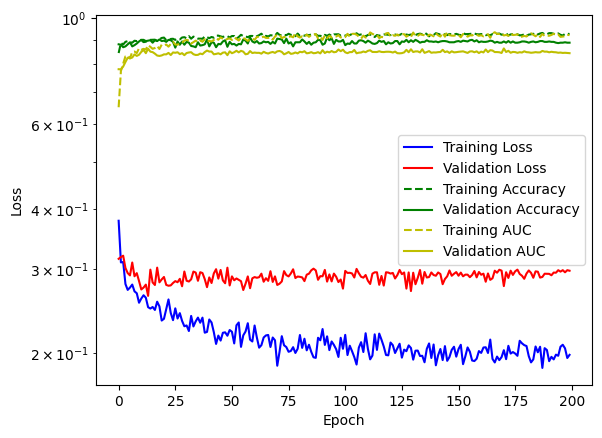

Epoch:0, Training_loss:0.3775, Training_acc:0.8441, Training_auc:0.6508, Training_bal_acc:0.4990, Eval_loss:0.3145, Eval_acc:0.8802, Eval_auc:0.7812, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2358, Training_acc:0.9091, Training_auc:0.8761, Training_bal_acc:0.6661, Eval_loss:0.2883, Eval_acc:0.8958, Eval_auc:0.8388, Eval_bal_acc:0.6022
Epoch:40, Training_loss:0.2351, Training_acc:0.9064, Training_auc:0.8945, Training_bal_acc:0.6841, Eval_loss:0.2877, Eval_acc:0.8715, Eval_auc:0.8502, Eval_bal_acc:0.7170
Epoch:60, Training_loss:0.2284, Training_acc:0.9110, Training_auc:0.8993, Training_bal_acc:0.7054, Eval_loss:0.2881, Eval_acc:0.8872, Eval_auc:0.8460, Eval_bal_acc:0.6936
Epoch:80, Training_loss:0.2182, Training_acc:0.9162, Training_auc:0.9092, Training_bal_acc:0.7141, Eval_loss:0.2884, Eval_acc:0.8889, Eval_auc:0.8493, Eval_bal_acc:0.7067
Epoch:100, 

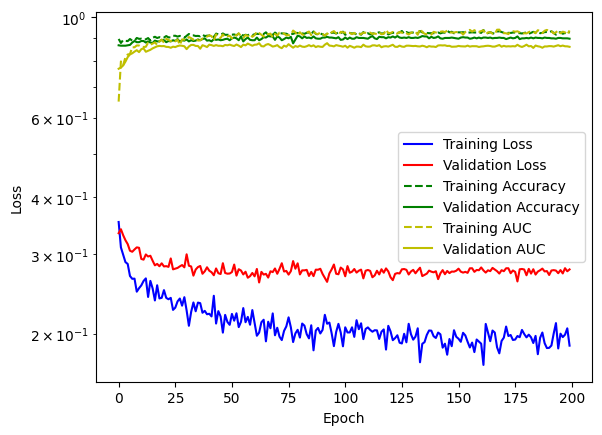

Epoch:0, Training_loss:0.3531, Training_acc:0.8946, Training_auc:0.6509, Training_bal_acc:0.5016, Eval_loss:0.3336, Eval_acc:0.8663, Eval_auc:0.7691, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2498, Training_acc:0.9011, Training_auc:0.8781, Training_bal_acc:0.6632, Eval_loss:0.2817, Eval_acc:0.8889, Eval_auc:0.8630, Eval_bal_acc:0.6492
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2215, Training_acc:0.9103, Training_auc:0.9111, Training_bal_acc:0.7010, Eval_loss:0.2757, Eval_acc:0.8889, Eval_auc:0.8691, Eval_bal_acc:0.6546
saving best...
saving best...
saving best...
saving best...
Epoch:60, Training_loss:0.2116, Training_acc:0.9165, Training_auc:0.9123, Training_bal_acc:0.7108, Eval_loss:0.2679, Eval_acc:0.8889, Eval_auc:0.8688, Eval_ba

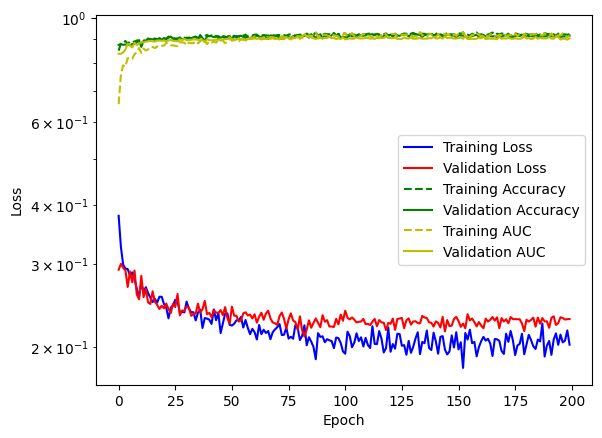

Epoch:0, Training_loss:0.3795, Training_acc:0.8504, Training_auc:0.6548, Training_bal_acc:0.5062, Eval_loss:0.2916, Eval_acc:0.8750, Eval_auc:0.8380, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2466, Training_acc:0.9030, Training_auc:0.8720, Training_bal_acc:0.6538, Eval_loss:0.2414, Eval_acc:0.9045, Eval_auc:0.8929, Eval_bal_acc:0.7216
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2285, Training_acc:0.9127, Training_auc:0.8903, Training_bal_acc:0.6847, Eval_loss:0.2362, Eval_acc:0.9132, Eval_auc:0.8958, Eval_bal_acc:0.7361
saving best...
Epoch:60, Training_loss:0.2148, Training_acc:0.9196, Training_auc:0.9117, Training_bal_acc:0.7295, Eval_loss:0.2345, Eval_acc:0.9080, Eval_auc:0.9033, Eval_bal_acc:0.8009
saving best...
saving best...
Epoch:80, Training_loss:0.2067, Training_acc:0.

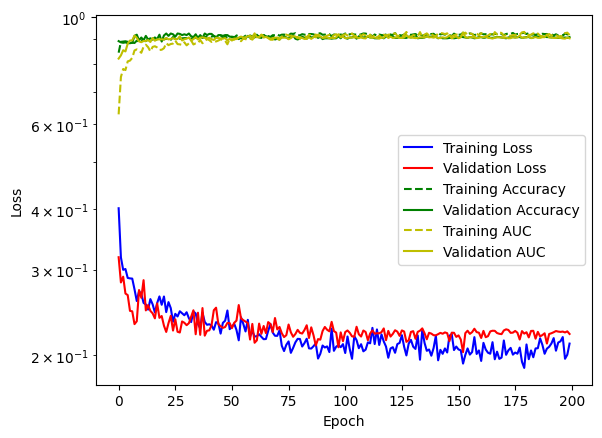

Epoch:0, Training_loss:0.4018, Training_acc:0.8430, Training_auc:0.6284, Training_bal_acc:0.4954, Eval_loss:0.3182, Eval_acc:0.8906, Eval_auc:0.8196, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2639, Training_acc:0.8977, Training_auc:0.8610, Training_bal_acc:0.6336, Eval_loss:0.2297, Eval_acc:0.9149, Eval_auc:0.8970, Eval_bal_acc:0.7739
Epoch:40, Training_loss:0.2312, Training_acc:0.9103, Training_auc:0.8949, Training_bal_acc:0.6984, Eval_loss:0.2246, Eval_acc:0.9219, Eval_auc:0.9050, Eval_bal_acc:0.7616
Epoch:60, Training_loss:0.2181, Training_acc:0.9173, Training_auc:0.9085, Training_bal_acc:0.7313, Eval_loss:0.2117, Eval_acc:0.9062, Eval_auc:0.9242, Eval_bal_acc:0.7914
saving best...
Epoch:80, Training_loss:0.2156, Training_acc:0.9154, Training_auc:0.9002, Training_bal_acc:0.6989, Eval_loss:0.2220, Eval_acc:0.9028, Eval_auc:0.9059, Eval_bal_acc:0.7666
Epoch:100, Training_loss:0

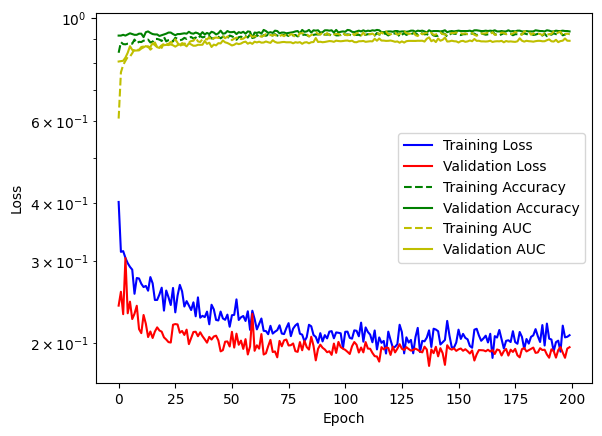

Epoch:0, Training_loss:0.4013, Training_acc:0.8403, Training_auc:0.6066, Training_bal_acc:0.4927, Eval_loss:0.2401, Eval_acc:0.9149, Eval_auc:0.8047, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2343, Training_acc:0.9085, Training_auc:0.8829, Training_bal_acc:0.6604, Eval_loss:0.2052, Eval_acc:0.9201, Eval_auc:0.8725, Eval_bal_acc:0.6880
saving best...
Epoch:40, Training_loss:0.2189, Training_acc:0.9129, Training_auc:0.9077, Training_bal_acc:0.7072, Eval_loss:0.2057, Eval_acc:0.9219, Eval_auc:0.8832, Eval_bal_acc:0.7444
saving best...
Epoch:60, Training_loss:0.2248, Training_acc:0.9066, Training_auc:0.9117, Training_bal_acc:0.7277, Eval_loss:0.1920, Eval_acc:0.9288, Eval_auc:0.8877, Eval_bal_acc:0.7205
saving best...
Epoch:80, Training_loss:0.2089, Training_acc:0.9144, Training_auc:0.9257, Training_bal_acc:0.7331, Eval_loss:0.2005, Eval_acc:0.9253, Eval_auc:0.8857, E

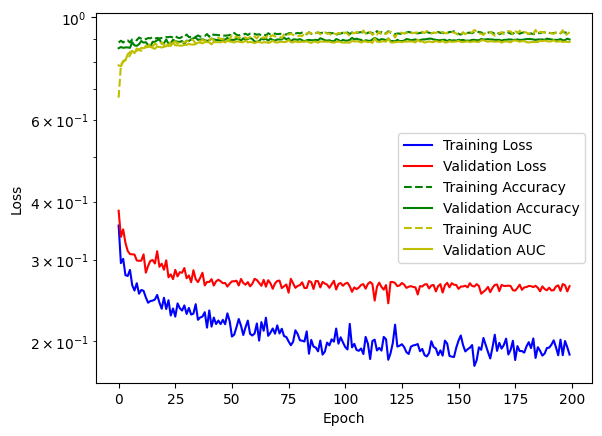

Epoch:0, Training_loss:0.3556, Training_acc:0.8822, Training_auc:0.6709, Training_bal_acc:0.4984, Eval_loss:0.3828, Eval_acc:0.8576, Eval_auc:0.7877, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2484, Training_acc:0.9013, Training_auc:0.8706, Training_bal_acc:0.6561, Eval_loss:0.2855, Eval_acc:0.8785, Eval_auc:0.8637, Eval_bal_acc:0.7220
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2332, Training_acc:0.9082, Training_auc:0.8929, Training_bal_acc:0.6865, Eval_loss:0.2686, Eval_acc:0.8924, Eval_auc:0.8824, Eval_bal_acc:0.6911
saving best...
saving best...
saving best...
saving best...
Epoch:60, Training_loss:0.2080, Training_acc:0.9213, Training_auc:0.9094, Training_bal_acc:0.7139, Eval_loss:0.2730, Eval_acc:0.8872, Eval_auc:0.8796, Eval_bal_acc:0.7217
sa

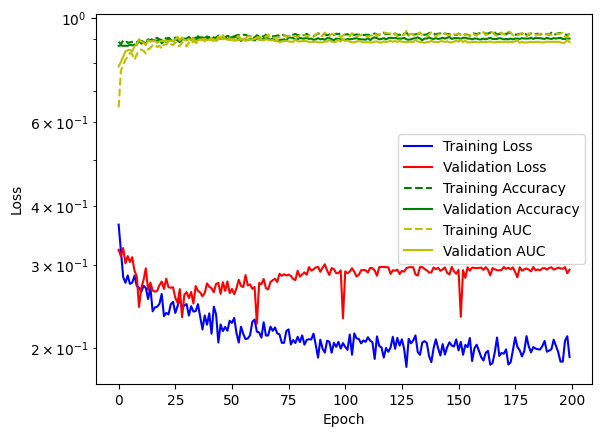

Epoch:0, Training_loss:0.3649, Training_acc:0.8891, Training_auc:0.6454, Training_bal_acc:0.5000, Eval_loss:0.3228, Eval_acc:0.8715, Eval_auc:0.7881, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2336, Training_acc:0.9074, Training_auc:0.8777, Training_bal_acc:0.6283, Eval_loss:0.2668, Eval_acc:0.8924, Eval_auc:0.8927, Eval_bal_acc:0.6983
saving best...
Epoch:40, Training_loss:0.2368, Training_acc:0.9064, Training_auc:0.8985, Training_bal_acc:0.7031, Eval_loss:0.2695, Eval_acc:0.9045, Eval_auc:0.8972, Eval_bal_acc:0.7462
Epoch:60, Training_loss:0.2298, Training_acc:0.9074, Training_auc:0.9009, Training_bal_acc:0.6849, Eval_loss:0.2692, Eval_acc:0.8941, Eval_auc:0.9002, Eval_bal_acc:0.7088
Epoch:80, Training_loss:0.2059, Training_acc:0.9200, Training_auc:0.9181, Training_bal_acc:0.7244, Eval_loss:0.2831, Eval_acc:0.9062, Eval_auc:0.8898, Eval_bal_acc:0.7

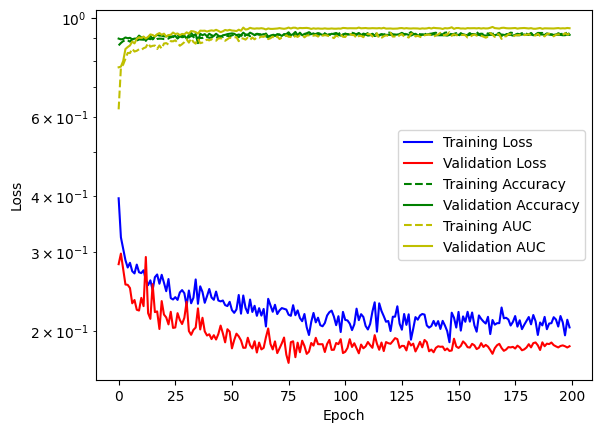

Epoch:0, Training_loss:0.3949, Training_acc:0.8668, Training_auc:0.6239, Training_bal_acc:0.5028, Eval_loss:0.2815, Eval_acc:0.8976, Eval_auc:0.7745, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2559, Training_acc:0.8954, Training_auc:0.8751, Training_bal_acc:0.6473, Eval_loss:0.2172, Eval_acc:0.9080, Eval_auc:0.9206, Eval_bal_acc:0.6835
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2477, Training_acc:0.9011, Training_auc:0.8892, Training_bal_acc:0.6653, Eval_loss:0.1963, Eval_acc:0.9201, Eval_auc:0.9341, Eval_bal_acc:0.7169
saving best...
saving best...
saving best...
saving best...
Epoch:60, Training_loss:0.2272, Training_acc:0.9144, Training_auc:0.8942, Training_bal_acc:0.7061, Eval_loss:0.1894, Eval_acc:0.9132, Eval_auc:0.9445, Eval_bal_acc:0.7925
sa

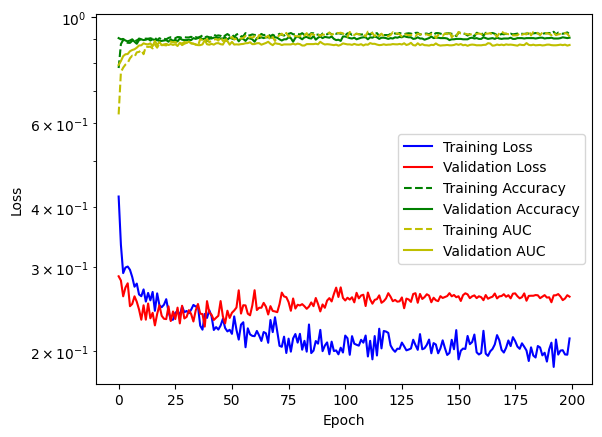

Epoch:0, Training_loss:0.4211, Training_acc:0.7816, Training_auc:0.6253, Training_bal_acc:0.5102, Eval_loss:0.2869, Eval_acc:0.9028, Eval_auc:0.7933, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2502, Training_acc:0.9000, Training_auc:0.8732, Training_bal_acc:0.6610, Eval_loss:0.2338, Eval_acc:0.8924, Eval_auc:0.8758, Eval_bal_acc:0.6172
saving best...
Epoch:40, Training_loss:0.2436, Training_acc:0.9062, Training_auc:0.8853, Training_bal_acc:0.6903, Eval_loss:0.2413, Eval_acc:0.9010, Eval_auc:0.8746, Eval_bal_acc:0.6924
Epoch:60, Training_loss:0.2150, Training_acc:0.9165, Training_auc:0.9112, Training_bal_acc:0.7228, Eval_loss:0.2683, Eval_acc:0.8872, Eval_auc:0.8773, Eval_bal_acc:0.7676
Epoch:80, Training_loss:0.2175, Training_acc:0.9183, Training_auc:0.9109, Training_bal_acc:0.7214, Eval_los

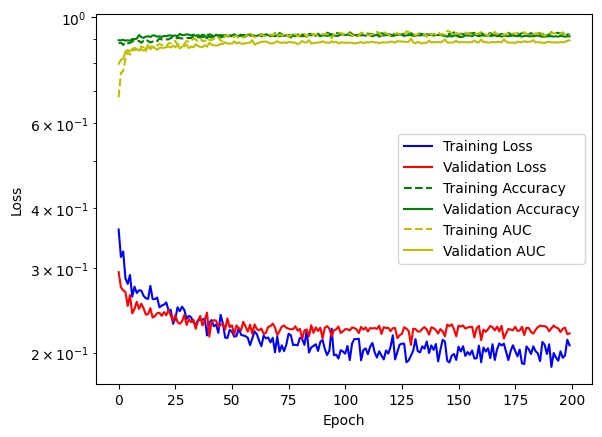

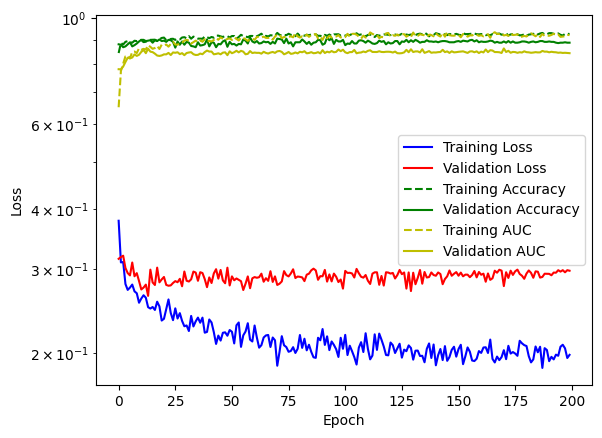

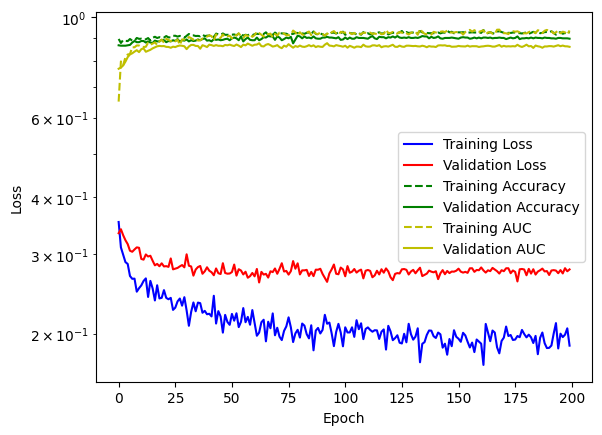

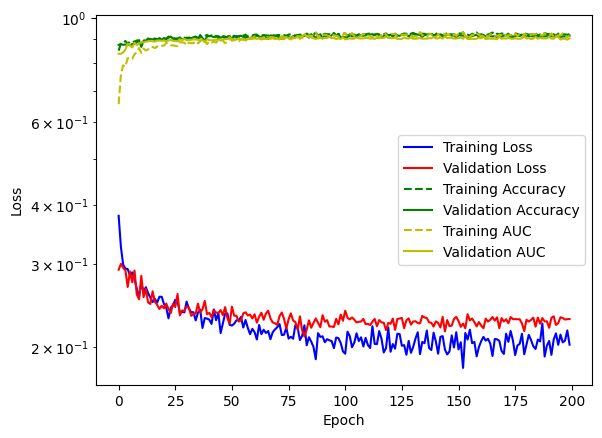

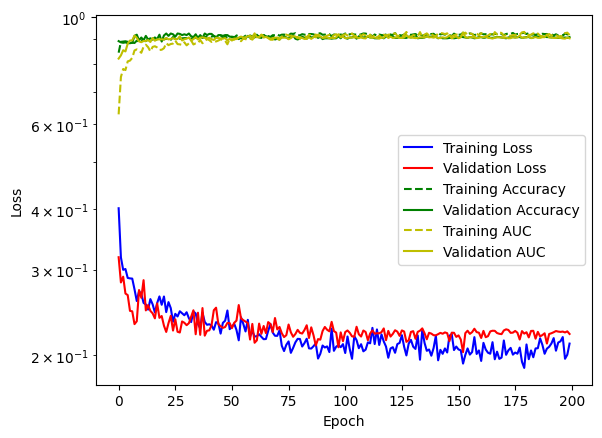

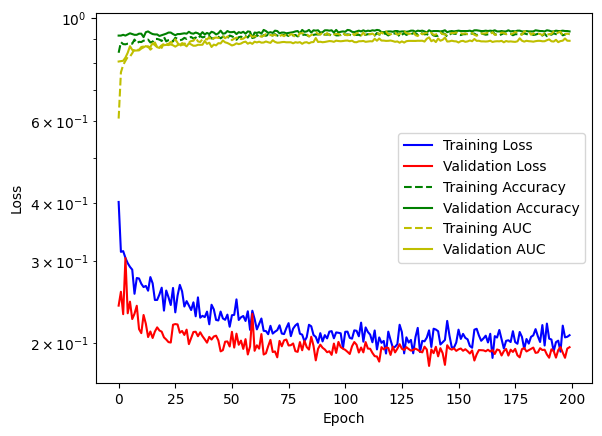

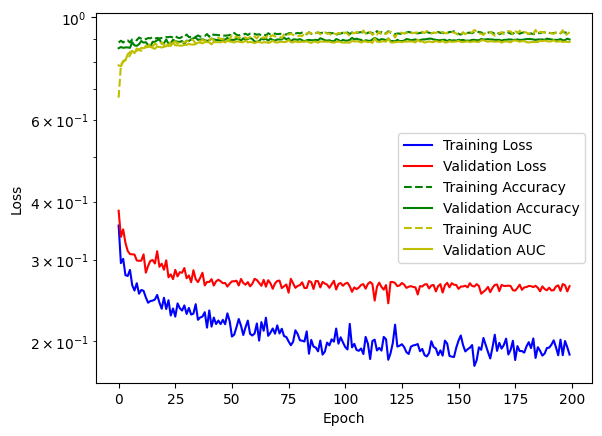

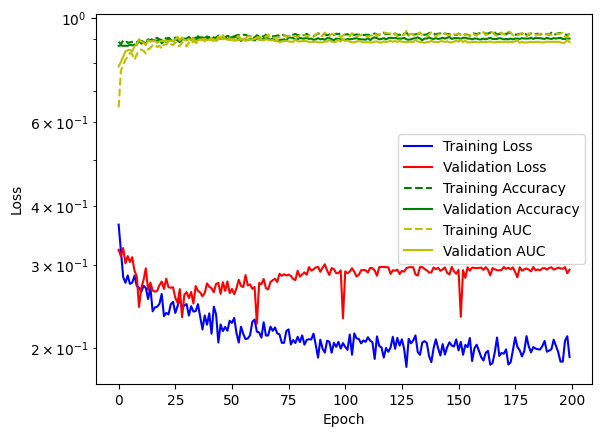

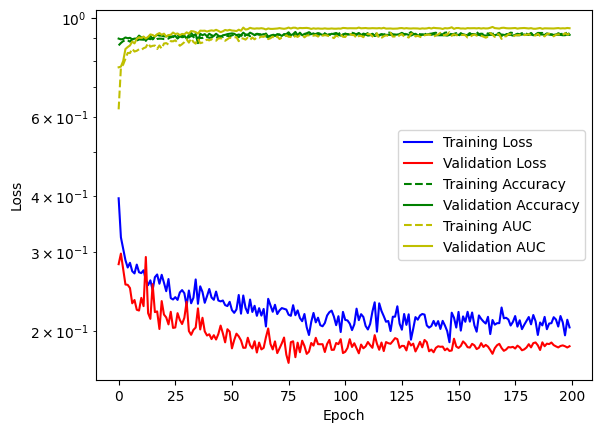

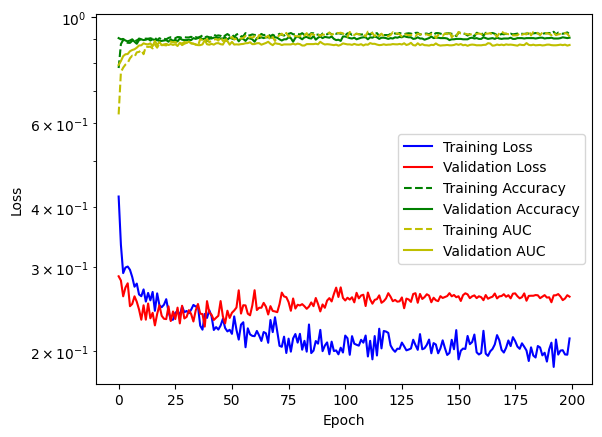

In [10]:
batch_size = 64

do = 0.4
num_layer = 4
num_hidden = 64
lr = 0.001

best_acc_list = []
best_auc_list = []
best_bal_acc_list = []

for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
    trainfold = train_set[train_index]
    valfold = train_set[test_index]
    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

    model = simpleGAT(in_channels=trainfold[0].x.size(1), dim_h=num_hidden, out_channels=trainfold[0].y.size(0), num_layers=num_layer, heads=4, dropout=do).to(device)

    trainer = Trainer(model=model,
                      train_loader=train_dataloader,
                      val_loader=val_dataloader,
                      test_loader=None,
                      device=device,
                      save_dir=os.path.join(os.getcwd(),'models/GAT/cross-val'),
                      save_name='GAT_' + str(i))
    train_params = {'num_epochs': 200,
                    'num_early_stop': 0,
                    'step': 20,
                    'gamma': 0.5}
                    
    optimizer_params = {'lr': lr,
                        'weight_decay': 1e-5}
                    
    best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)
    best_acc_list.append(best_eval_acc)
    best_auc_list.append(best_eval_auc)
    best_bal_acc_list.append(best_eval_bal_acc)

In [11]:
print(f'The model achieves accuracy={np.mean(best_acc_list):.4f}±{np.std(best_acc_list):.4f}, AUC={np.mean(best_auc_list):.4f}±{np.std(best_auc_list):.4f}' 
      f' and balanced accuracy={np.mean(best_bal_acc_list):.4f}±{np.std(best_bal_acc_list):.4f}')

The model achieves accuracy=0.9069±0.0124, AUC=0.8886±0.0263 and balanced accuracy=0.7488±0.0324


## 3. Evaluate Test Set
<a id='test'></a>

As a last step we train the model one last time on a radom subset of the training data (keeping 15% for validation) and then evaluate the test set with the model and compute the confusion matrix, the ROC curve and the Precision-Recall curve

In [12]:
batch_size = 64

do = 0.4
num_layer = 4
num_hidden = 64
lr = 0.001

train_final, _ , val_final = random_split_dataset(train_set, frac_train=0.85, frac_val=0.0, frac_test=0.15)

train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in train_final.y.view(-1,2)], dtype=torch.long))
train_dataloader = DataLoader(train_final, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
val_dataloader = DataLoader(val_final, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

model = simpleGAT(in_channels=train_final[0].x.size(1), dim_h=num_hidden, out_channels=train_final[0].y.size(0), num_layers=num_layer, heads=4, dropout=do).to(device)

trainer = Trainer(model=model,
                  train_loader=train_dataloader,
                  val_loader=val_dataloader,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='GAT')

train_params = {'num_epochs': 200,
                'num_early_stop': 0,
                'step': 20,
                'gamma': 0.5}
                    
optimizer_params = {'lr': lr,
                    'weight_decay': 1e-5}

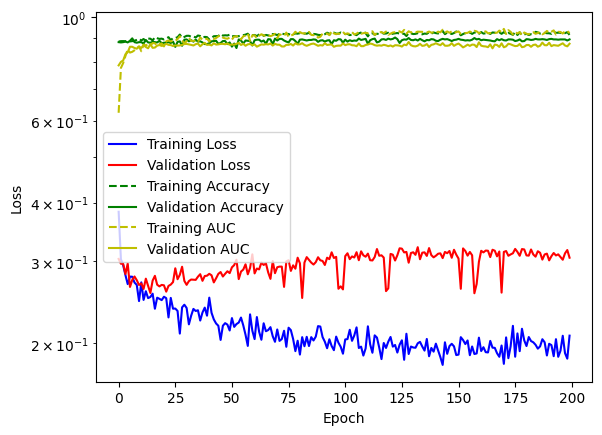

Epoch:0, Training_loss:0.3825, Training_acc:0.8862, Training_auc:0.6234, Training_bal_acc:0.4997, Eval_loss:0.3031, Eval_acc:0.8834, Eval_auc:0.7877, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2515, Training_acc:0.8952, Training_auc:0.8651, Training_bal_acc:0.6016, Eval_loss:0.2661, Eval_acc:0.8810, Eval_auc:0.8703, Eval_bal_acc:0.6048
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2503, Training_acc:0.8942, Training_auc:0.8861, Training_bal_acc:0.6643, Eval_loss:0.2816, Eval_acc:0.8786, Eval_auc:0.8726, Eval_bal_acc:0.7005
saving best...
Epoch:60, Training_loss:0.2040, Training_acc:0.9153, Training_auc:0.9137, Training_bal_acc:0.7225, Eval_loss:0.2822, Eval_acc:0.8918, Eval_auc:0.8740, Eval_bal_acc:0.7023
Epoch:80, Training_loss:0.1890, Training_acc:0.9239, Training_auc:0.9285, Training_bal_acc:0.7388, Eval_loss:0.2966, Eval_

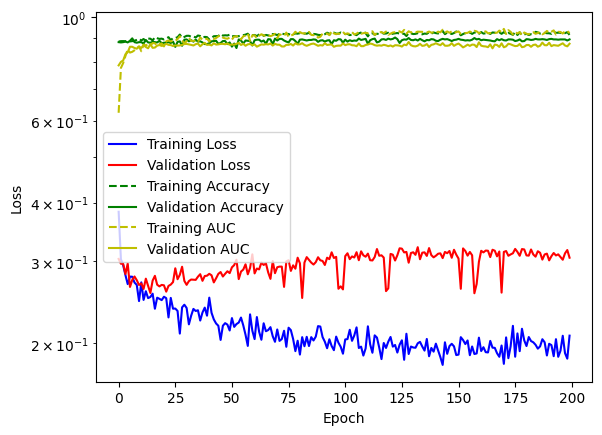

In [13]:
best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)

In [15]:
trainer.load_model()

test_loss, test_acc, test_auc,preds, pred_probs, labels = trainer.test()
print(balanced_accuracy_score(labels, preds).item())

Test loss: 0.2759, test acc 0.8953, test_auc 0.8882
0.7430736294181848


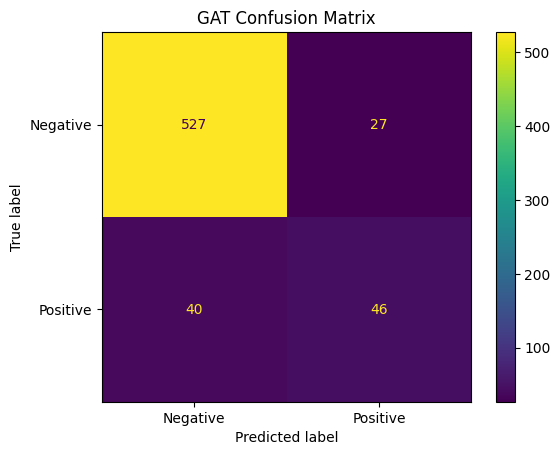

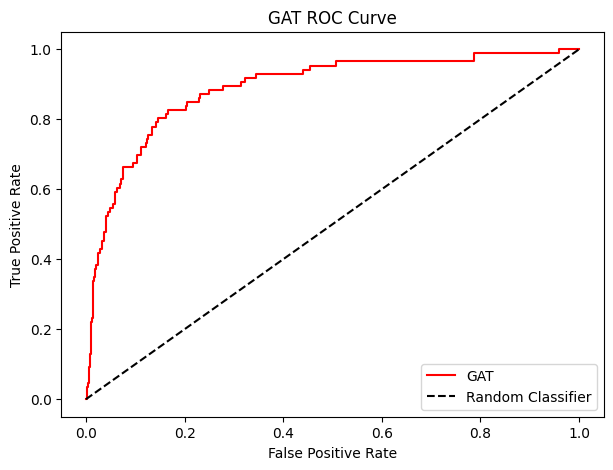

In [16]:
# Confusion matrix
c_matrix = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GAT Confusion Matrix") 
plt.savefig('GAT_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GAT")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("GAT ROC Curve") 
plt.legend() 
plt.savefig('GAT_ROC.pdf')
plt.show()

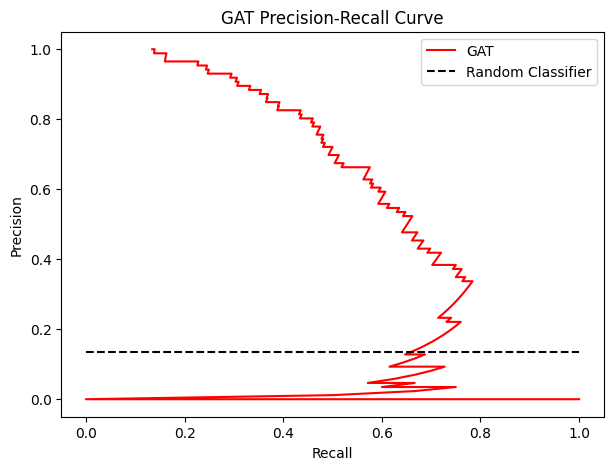

In [17]:
# AUC by class
pos_ratio = y_true_bin.sum().item()/len(y_true_bin)
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = precision_recall_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GAT")
plt.plot([0,1], [pos_ratio,pos_ratio], "k--", label="Random Classifier")
plt.xlabel("Recall") 
plt.ylabel("Precision")
plt.title("GAT Precision-Recall Curve") 
plt.legend() 
plt.savefig('GAT_PR_curve.pdf')
plt.show()